<center><h1>Combining GPU-Compatible Scanpy-Squidpy with Voyager</h1></center>

In this notebook, I will combine GPU-compatible Scanpy-Squidpy (`rapids_singlecell`) with Voyager.

For the first time, we will use `rapids_singlecell` to perform cell clustering on the 10x sample **Xenium_Prime_Human_Lymph_Node_Reactive_FFPE** from the internet.


In [4]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os
import gzip
import numpy as np
import scanpy as sc
import squidpy as sq
import cupy as cp
import cupyx
import os
import time
import rapids_singlecell as rsc
import numpy as np
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator
import cupy

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)
import zarr
from collections import OrderedDict
from scipy.sparse import csr_matrix
import pandas as pd
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from scipy.sparse import csr_matrix
import scipy
import anndata
from collections import OrderedDict
from rsc_functions.utility.applyqc import applyqc
from rsc_functions.reports.plot import plot_spatial,plot_spatial_data, plot_expression, plot_moran
from rsc_functions.utility.rank_genes_groups import return_markers,rank_genes_groups

In [5]:
path = "/data/kanferg/Sptial_Omics/playGround/Data/Xenium/output_temp"
pathout = "/data/kanferg/Sptial_Omics/SpatialOmicsToolkit/out_1"
FilePrefix = "_072824" 

In [6]:
path_xenium = os.path.join(path,"cell_feature_matrix.h5")
path_cells = os.path.join(path,"cells.zarr.zip")
adata = sc.read_10x_h5(path_xenium)
rsc.get.anndata_to_GPU(adata)
rsc.pp.flag_gene_family(adata, gene_family_name="MT", gene_family_prefix="mt-")
rsc.pp.calculate_qc_metrics(adata, qc_vars=["MT"])
def open_zarr(path: str) -> zarr.Group:
    store = (zarr.ZipStore(path, mode="r") if path.endswith(".zip") else zarr.DirectoryStore(path))
    return zarr.group(store=store)
root = open_zarr(path_cells)
column_names = dict(root['cell_summary'].attrs.items())['column_names']
def build_obs(andata,root,column_names):
    for i in range(len(column_names)):
        andata.obs[str(column_names[i])] = np.array(root["cell_summary"])[:,i]
    spatial = andata.obs[["cell_centroid_x", "cell_centroid_y"]]
    adata.obsm["spatial"] = spatial.values
    return andata
andata = build_obs(adata,root,column_names)
andata.var_names_make_unique()
andata.obsm['spatial'] = np.array(andata.obsm['spatial'], dtype=np.float64)
andata.uns['config'] = OrderedDict()
andata.uns["config"]["secondary_var_names"] = andata.var_names
rsc.pp.flag_gene_family(andata, gene_family_name="MT", gene_family_prefix="mt-")
rsc.pp.calculate_qc_metrics(andata, qc_vars=["MT"])
rsc.pp.filter_cells(andata, min_count=10,qc_var = 'total_counts')
rsc.pp.filter_genes(andata, min_count=5)
andata.layers['counts'] = andata.X.copy()
rsc.pp.normalize_total(andata)
rsc.pp.log1p(andata)
andata.layers['log'] = andata.X.copy()
rsc.pp.highly_variable_genes(andata, n_top_genes=1500, flavor="seurat_v3", layer="log")
andata = andata[:, andata.var["highly_variable"]]
rsc.pp.scale(andata, max_value=10)
rsc.pp.pca(andata, n_comps=30,random_state=1337, use_highly_variable=False)

filtered out 3685 cells
filtered out 1 genes based on n_cells_by_counts


/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/rapids_singlecell/preprocessing/_hvg.py:517: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/rapids_singlecell/preprocessing/_scale.py:71: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


In [7]:
andata = andata[:, andata.var["highly_variable"]]
andata

View of AnnData object with n_obs × n_vars = 705298 × 1500
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'nucleus_count'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'config', 'log1p', 'hvg', 'pca'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'log'

In [8]:
rsc.pp.scale(andata, max_value=10)

/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/rapids_singlecell/preprocessing/_scale.py:71: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [9]:
rsc.pp.pca(andata, n_comps=30,random_state=1337, use_highly_variable=False)

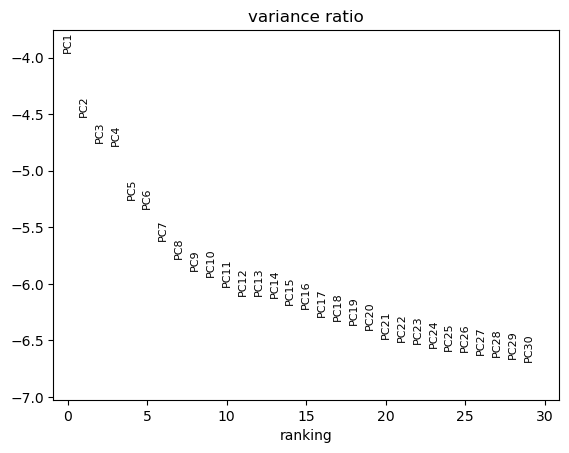

In [10]:
sc.pl.pca_variance_ratio(andata, log=True, n_pcs=30)

In [13]:
rsc.pp.neighbors(andata, n_pcs=18, use_rep='X_pca', n_neighbors=20)
rsc.tl.leiden(andata, random_state=1337, resolution=0.8, key_added='cluster') 

The function `plot_spatial` was created to display the sum count per cell (library depth).

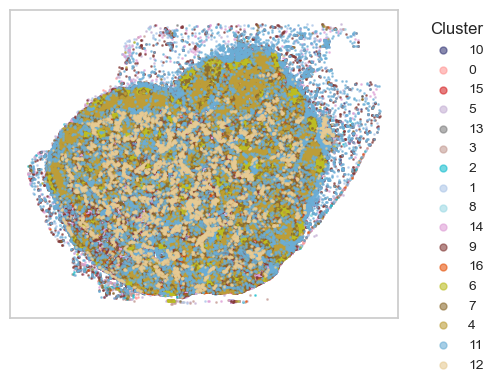

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_spatial(andata,ax = ax, features = None, title = '', xlab = '',ylab ='',size = 1,random_palette = True)

In [15]:
rsc.tl.umap(andata, min_dist=0.3)

In [16]:
umap_coordinates = andata.obsm['X_umap']
print("UMAP Coordinate Ranges:")
print(f"UMAP 1: {umap_coordinates[:, 0].min()} to {umap_coordinates[:, 0].max()}")
print(f"UMAP 2: {umap_coordinates[:, 1].min()} to {umap_coordinates[:, 1].max()}")


UMAP Coordinate Ranges:
UMAP 1: -9.117500305175781 to 14.65951919555664
UMAP 2: -8.40682601928711 to 9.119938850402832


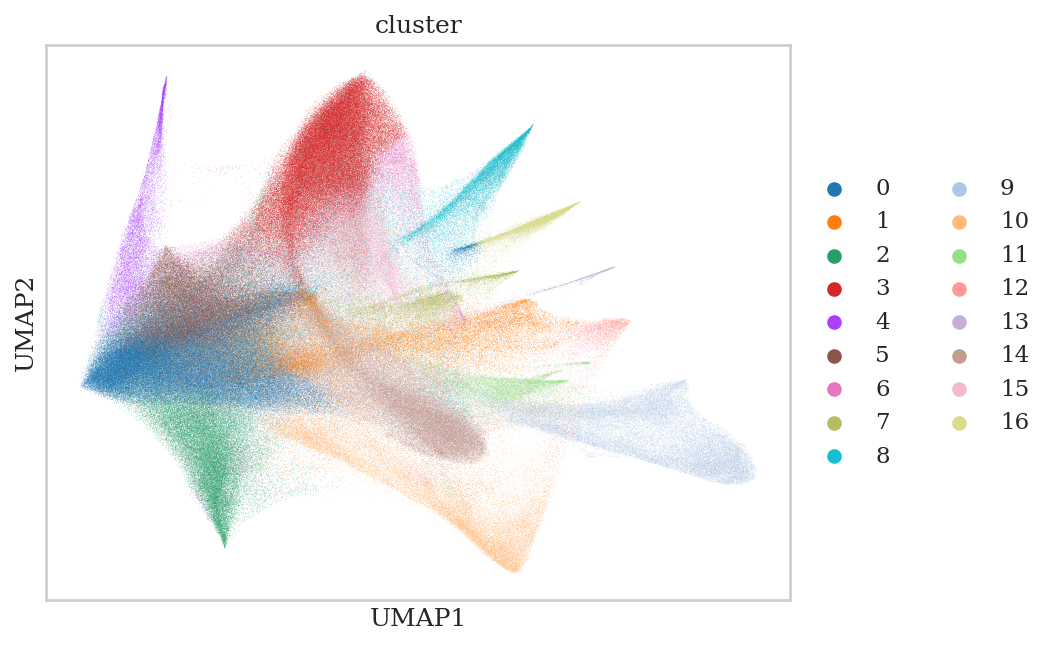

In [17]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
#fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sc.pl.umap(andata, color=['cluster'])

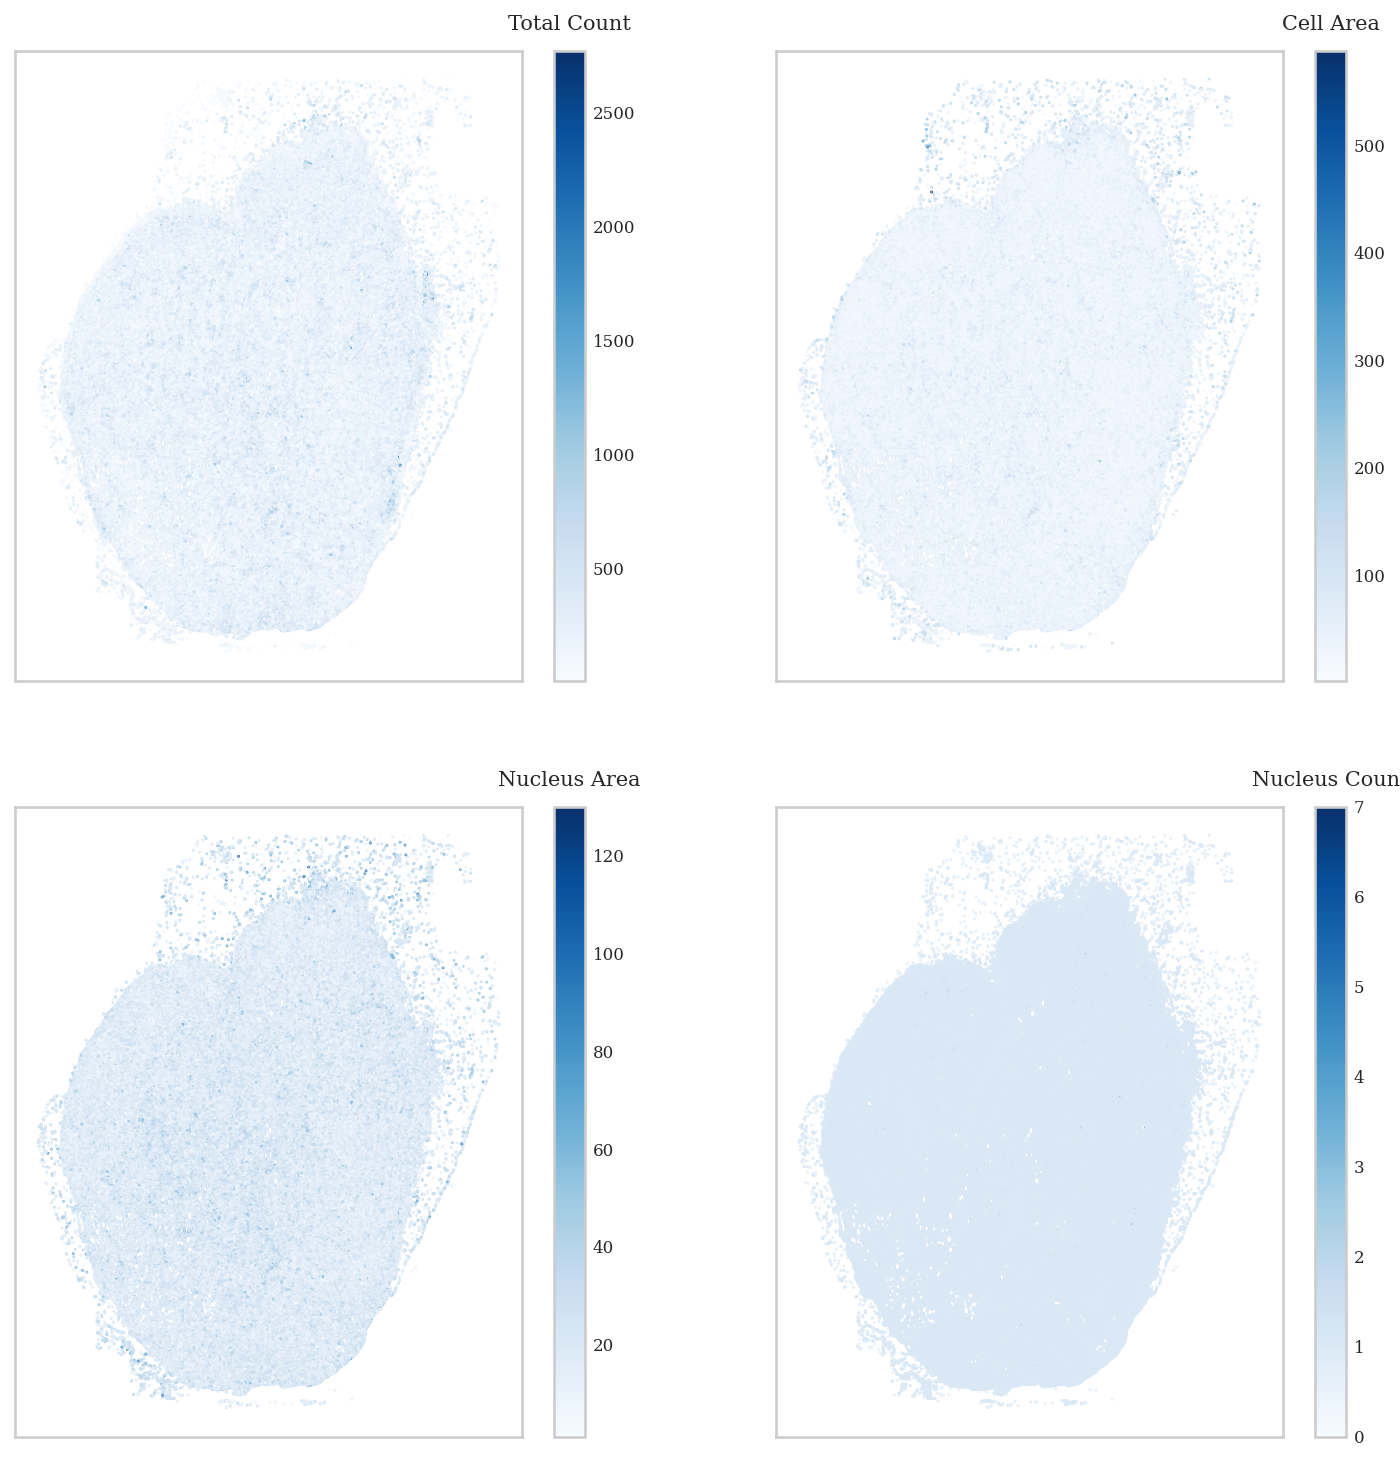

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax = ax.ravel()
plot_spatial_data(andata, 'total_counts', fig = fig , ax = ax[0],set_xlabel_cbar = 'Total Count',size = 0.1)
plot_spatial_data(andata, 'cell_area', fig = fig, ax = ax[1],set_xlabel_cbar = 'Cell Area',size = 0.1)
plot_spatial_data(andata, 'nucleus_area', fig = fig , ax = ax[2],set_xlabel_cbar = 'Nucleus Area',size = 0.1)
plot_spatial_data(andata, 'nucleus_count', fig = fig , ax = ax[3],set_xlabel_cbar = 'Nucleus Count',size = 0.1)

Next, we will save a CPU version of the AnnData object so we can perform differential gene expression analysis using the Scanpy function `rank_genes_groups`.

In [18]:
rsc.get.anndata_to_CPU(andata)

In [20]:
sc.tl.rank_genes_groups(andata, groupby="cluster", method="wilcoxon")

/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_sing

In [21]:
andata

AnnData object with n_obs × n_vars = 705298 × 1500
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'nucleus_count', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'config', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'cluster_colors', 'rank_genes_groups'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log'
    obsp: 'distances', 'connectivities'

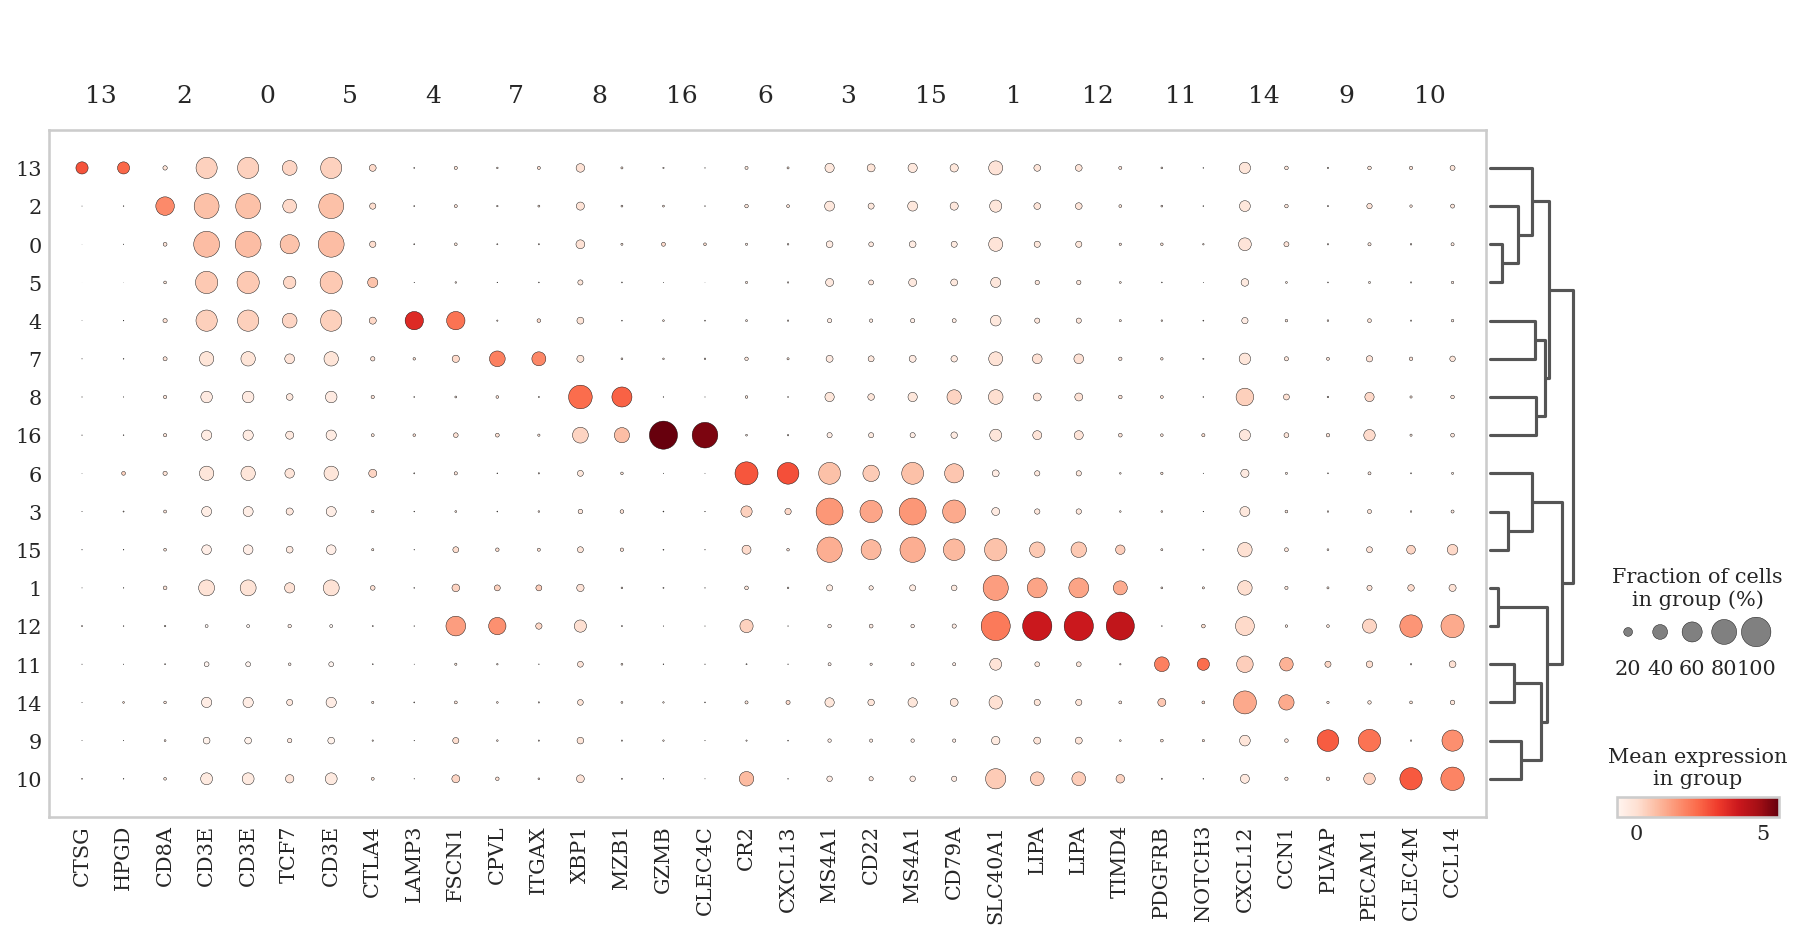

In [22]:
sc.pl.rank_genes_groups_dotplot(andata, groupby="cluster",n_genes=2)

In [23]:
import squidpy as sq
sq.gr.spatial_neighbors(andata, coord_type="generic",delaunay = True)
sq.gr.nhood_enrichment(andata, cluster_key="cluster")

/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|████████████████████████████████████████████████████████████████████| 1000/1000 [00:45<00:00, 22.14/s]


/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/usr/local/apps/rapids-singlecell/mamba/envs/rapids_singlecell/lib/python3.11/site-packages/squidpy/pl/_utils.py:555: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


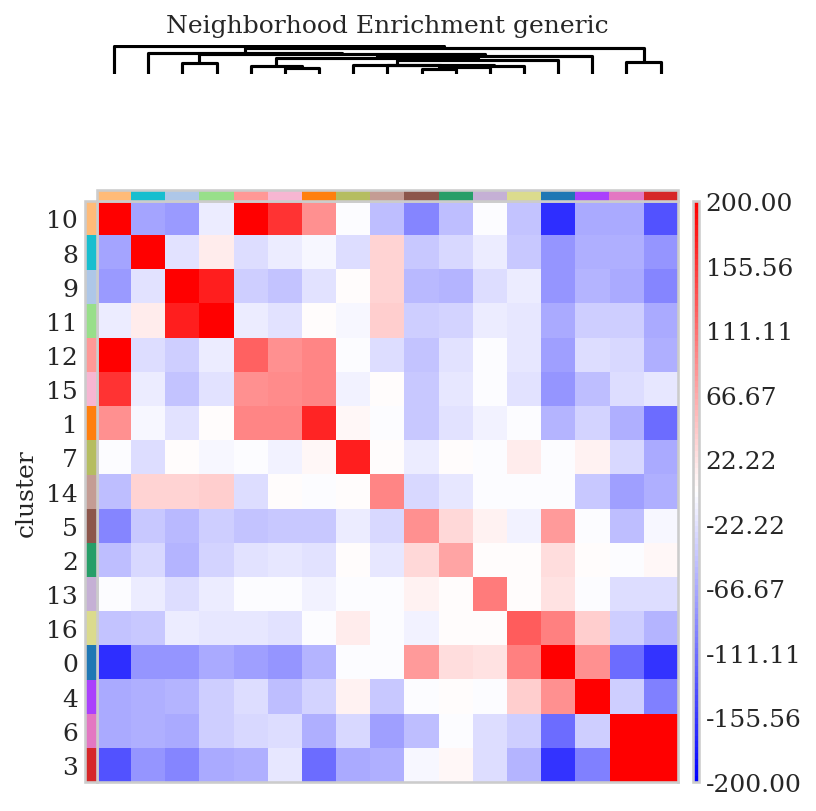

In [24]:
from matplotlib.colors import LinearSegmentedColormap

colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # Blue -> White -> Red
n_bins = 100  # Discretize into 100 bins
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=n_bins)

plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

sq.pl.nhood_enrichment(
    andata,
    title = "Neighborhood Enrichment generic",
    cluster_key="cluster",
    method="average",
    cmap=custom_cmap,
    vmin=-200,
    vmax=200,
    figsize=(5, 5),
)

In [32]:
rsc.pp.neighbors(andata, n_pcs=15, use_rep='X_pca', n_neighbors=30,key_added = 'knn')

AnnData object with n_obs × n_vars = 705298 × 1500
    obs: 'n_genes_by_counts', 'total_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'cell_centroid_x', 'cell_centroid_y', 'cell_area', 'nucleus_centroid_x', 'nucleus_centroid_y', 'nucleus_area', 'z_level', 'nucleus_count', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'MT', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'config', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'cluster_colors', 'rank_genes_groups', 'dendrogram_cluster', 'spatial_neighbors', 'cluster_nhood_enrichment', 'knn'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'log'
    obsp: 'distances', 'connectivities', 'spatial_connectivities', 'spatial_distances', 'knn_distance